In [1]:
#imports

import numpy as np
import pandas as pd
import nltk
import collections as co
import StringIO
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, HTML, Markdown, display

#constants
%matplotlib inline
def printmd(string):
    display(Markdown(string))
alphaLev = .5

In [2]:
#load in dataset
complaintFrame = pd.read_csv("../data/consumer_complaints.csv")

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# CFPB Consumer Complaints: Language Analysis

In this notebook, I will perform EDA and language analysis on the text-sensitive data found in the [CFPB Consumer Complaints](https://www.kaggle.com/cfpb/us-consumer-finance-complaints) dataset. You can find my analysis on the non-text-sensitve EDA within [this script](https://www.kaggle.com/mmrosenb/d/cfpb/us-consumer-finance-complaints/eda-on-consumer-complaints). As we saw in some summary statistics within that script, about $432499$ observations do not have text-sensitive data, which makes this section a general down-sizing our sample. That being said, this section potentially carries the most important aspects of the consumer complaint.

We will start by pre-processing our text data. Some of the code below is adapted from [Mike Chirico's EDA](https://www.kaggle.com/mchirico/d/cfpb/us-consumer-finance-complaints/analyzing-text-in-consumer-complaints).

In [3]:
#consider only narrative observations
complaintNarrativeFrame = complaintFrame[complaintFrame["consumer_complaint_narrative"].notnull()]
# build a fast way to get strings
# adapted from 
# https://www.kaggle.com/mchirico/d/cfpb/us-consumer-finance-complaints/analyzing-text-in-consumer-complaints
s = StringIO.StringIO()
complaintNarrativeFrame["consumer_complaint_narrative"].apply(lambda x: s.write(x))
k=s.getvalue()
s.close()
k=k.lower()
k=k.split()

In [4]:
# Next only want valid strings
words = co.Counter(nltk.corpus.words.words())
stopWords =co.Counter( nltk.corpus.stopwords.words() )
k=[i for i in k if i in words and i not in stopWords]
c = co.Counter(k)
printmd("We see that we $" + str(len(k)) + "$ legal word tokens in our corpus. There are $" + str(
        len(list(c.most_common())))
       + "$ legal non-stopword types in our corpus.")

We see that we $3707242$ legal word tokens in our corpus. There are $13962$ legal non-stopword types in our corpus.

As discussed on [Mike Chirico's EDA](https://www.kaggle.com/mchirico/d/cfpb/us-consumer-finance-complaints/analyzing-text-in-consumer-complaints), `k` represents the array of all legal words with stopwords removed for the sentences concatenated, and `c` represents  a per-word counter over the legal words within our dataset. Let us take a look at the rank-frequency graph of our vocabulary, the $15$ most common words, and the $15$ least common words.

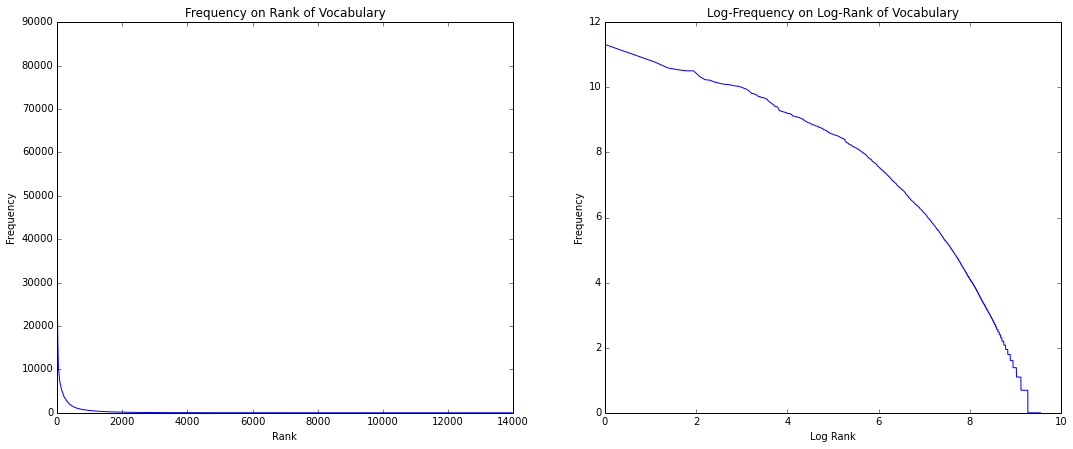

_Figure 1: Frequency-Rank Graphs of Our Vocabulary._

,Word,Frequency
0,credit,82342
1,account,58454
2,would,47840
3,loan,39920
4,bank,37751
5,told,36548
6,payment,36509
7,received,30722
8,debt,27829
9,mortgage,27401


_Table 1: The $15$ most frequent words with their frequencies_

,Word,Frequency
13947,trimester,1
13948,sufferer,1
13949,resumption,1
13950,atter,1
13951,demonize,1
13952,cave,1
13953,unusualness,1
13954,withstood,1
13955,exclamation,1
13956,gat,1


_Table 2: The $15$ least frequent words with their frequencies_

In [5]:
wordFrequencyFrame = pd.DataFrame(c.most_common(len(c)),columns = ["Word","Frequency"])
#plot frequency on rank
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
#freq-rank
ax1.plot(wordFrequencyFrame.index,wordFrequencyFrame["Frequency"])
ax1.set_title("Frequency on Rank of Vocabulary")
ax1.set_xlabel("Rank")
ax1.set_ylabel("Frequency")
#freq-logRank
ax2.plot(np.log(wordFrequencyFrame.index + 1),np.log(wordFrequencyFrame["Frequency"]))
ax2.set_title("Log-Frequency on Log-Rank of Vocabulary")
ax2.set_xlabel("Log Rank")
ax2.set_ylabel("Frequency")
plt.show()
printmd("_Figure 1: Frequency-Rank Graphs of Our Vocabulary._")
#get 15 most common
top15FrequencyFrame = wordFrequencyFrame.iloc[0:15,:]
display(top15FrequencyFrame)
printmd("_Table 1: The $15$ most frequent words with their frequencies_")
#get 15 least common
bottom15FrequencyFrame = wordFrequencyFrame.iloc[(wordFrequencyFrame.shape[0]-15):wordFrequencyFrame.shape[0],:]
display(bottom15FrequencyFrame)
printmd("_Table 2: The $15$ least frequent words with their frequencies_")

We see by the log-frequency on log-rank graph (Figure 1, right) that fitting a [Zipf Distribution](https://en.wikipedia.org/wiki/Zipf%27s_law) to this graph may potentially over-prediction the probability of less frequent words occuring, which suggests that our vocabulary is much more right-skewed than in a more ideal vocabulary. We see that the 15 most common words portray words that are very financially relevant, such as credit, account, loan, and bank.

Let us now view the token-type graph to study richness of the vocabulary in the corpus.

In [6]:
#get token-type list
typeSet = set([]) #we will add to this over time
typeTokenList = [] #we will add tuples to this
for i in xrange(len(k)):
    givenToken = k[i]
    if (givenToken not in typeSet): #we should get a new type count
        typeSet.add(givenToken)
    #then add information to type-token list
    typeTokenList.append((i+1,len(typeSet)))

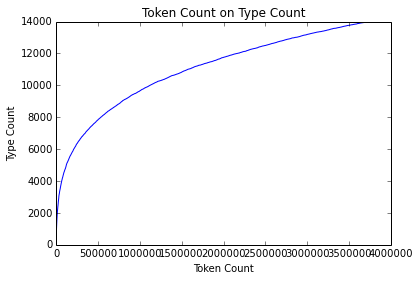

_Figure 2: Type-Token Graph for full vocabulary._

In [7]:
#then plot
typeTokenFrame = pd.DataFrame(typeTokenList,columns = ["Token Count","Type Count"])
plt.plot(typeTokenFrame["Token Count"],typeTokenFrame["Type Count"])
plt.xlabel("Token Count")
plt.ylabel("Type Count")
plt.title("Token Count on Type Count")
plt.show()
printmd("_Figure 2: Type-Token Graph for full vocabulary._")

We see that the growth of our vocabulary begins to slow after around $1000000$ tokens in our corpus, which is about $27\%$ of the way through our corpus. To me, this suggests that the vocabulary is not extremely diverse, although it is difficult to compare without studying the relationship with other corpora.

It would be very interesting to see if the richness of vocabulary changes based on the product being addressed. Let us take a look at the distribution of products over observations with complaint narratives and the type-token graphs for each product.

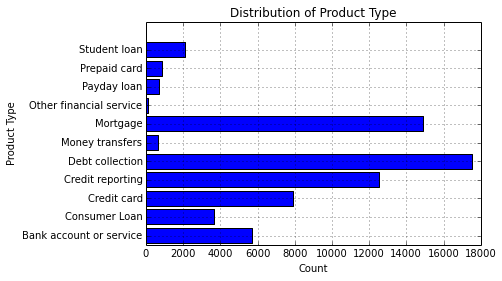

_Figure 3: Distribution of product types._

The number of narratives of the product type 'Other financial service' is $110$.

In [8]:
productCountFrame = complaintNarrativeFrame.groupby("product")["consumer_complaint_narrative"].count()
#from pylab import *
#val = 3+10*rand(5)    # the bar lengths
pos = np.arange(productCountFrame.shape[0])+.5    # the bar centers on the y axis

plt.barh(pos,productCountFrame, align='center')
plt.yticks(pos,productCountFrame.index)
plt.xlabel('Count')
plt.ylabel("Product Type")
plt.title('Distribution of Product Type')
plt.grid(True)
plt.show()
printmd("_Figure 3: Distribution of product types._")
printmd("The number of narratives of the product type 'Other financial service' is $" + str(
        productCountFrame["Other financial service"]) + "$.")

We see that our distribution seems very uneven, as we have a large amount of Mortgage, Debt Collection, and credit reporting narratives, but relatively few observations in money transfer, other financial services, and payday loans. This may suggest that it would be difficult to predict some of these smaller groups if we are interested in a predictive model on this issue.

In [9]:
#declare functions before making type-token procedures
def makeTypeTokenFrame(tokenList):
    #helper that makes our type-token frame for a given token list
    typeSet = set([]) #we will add to this over time
    typeTokenList = [] #we will add tuples to this
    for i in xrange(len(tokenList)):
        givenToken = tokenList[i]
        if (givenToken not in typeSet): #we should get a new type count
            typeSet.add(givenToken)
        #then add information to type-token list
        typeTokenList.append((i+1,len(typeSet)))
    return pd.DataFrame(typeTokenList,columns = ["Token Count","Type Count"])

def makeTokenList(consumerComplaintFrame):
    #helper that makes token list from the given complaint frame
    s = StringIO.StringIO()
    consumerComplaintFrame["consumer_complaint_narrative"].apply(lambda x: s.write(x))
    k = s.getvalue() #gets string of unprocessed words
    s.close()
    #get actual unprocessed words
    #k = k.lower()
    k = k.split()
    k = [i for i in k if i in words and i not in stopWords] #only consider legal words
    return k

def getTokenTypeFrameForProduct(consumerComplaintFrame,productName):
    #helper that gets our token-type frame for narratives of a given product name
    #get observations with this product name
    givenProductComplaintFrame = consumerComplaintFrame[consumerComplaintFrame["product"] == productName]
    #then get token list
    tokenList = makeTokenList(givenProductComplaintFrame)
    #then make type-token frame
    return makeTypeTokenFrame(tokenList)

In [10]:
#run through our observations
typeTokenFrameDict = {} #we will adds to this
for productName in productCountFrame.index:
    typeTokenFrameDict[productName] = getTokenTypeFrameForProduct(complaintNarrativeFrame,productName)

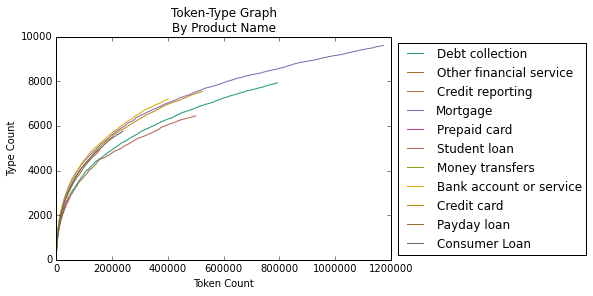

_Figure 4: Token-Type Graph By Product Name._

In [11]:
cmap = plt.get_cmap('Dark2')
colorList = [cmap(i) for i in np.linspace(0, 1, len(typeTokenFrameDict))]
for i in xrange(len(typeTokenFrameDict)):
    productName = list(typeTokenFrameDict)[i]
    givenProductTokenTypeFrame = typeTokenFrameDict[productName]
    plt.plot(givenProductTokenTypeFrame["Token Count"],
             givenProductTokenTypeFrame["Type Count"],label = productName,
            c = colorList[i])
plt.legend(bbox_to_anchor = (1.6,1))
plt.xlabel("Token Count")
plt.ylabel("Type Count")
plt.title("Token-Type Graph\nBy Product Name")
plt.show()
printmd("_Figure 4: Token-Type Graph By Product Name._")

This graph makes one obvious thing apparent: that there are many more mortgage complaint observations than other categories. While it is difficult to define which of these products have the richest vocabulary due to the difference in line lengths, it is very obvious that debt collection and credit reporting seem to have less rich vocabularies than the other products. This may be essential for distinguishing the groups, although it is currently difficult to tell why this is. I am open to discussion on possible hypotheses for this.

What may also be useful is to consider if we could predict whether a customer would eventually dispute the final resolution of a claim based on the language in the complaint itself. While it is likely this will also be a function of the company's decision of the company's response to the consumer, it may be interesting to study if vagueness or complexity of a dispute would factor into whether a consumer disputes a resolution.

In [12]:
def getTokenTypeFrameForDispute(consumerComplaintFrame,disputeLev):
    #helper that gets our token-type frame for narratives of a dispute level
    #get observations with this product name
    givenDisputeComplaintFrame = consumerComplaintFrame[consumerComplaintFrame["consumer_disputed?"] == disputeLev]
    #then get token list
    tokenList = makeTokenList(givenDisputeComplaintFrame)
    #then make type-token frame
    return makeTypeTokenFrame(tokenList)

In [13]:
consumerDisputeDict = {} #we will add to this
for disputeLev in complaintNarrativeFrame["consumer_disputed?"].unique():
    consumerDisputeDict[disputeLev] = getTokenTypeFrameForDispute(complaintNarrativeFrame,disputeLev)

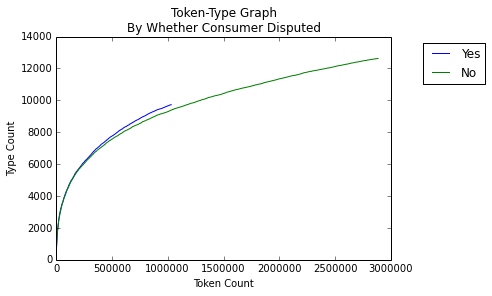

_Figure 5: Token-Type Graph By whether the consumer disputed._

In [14]:
for disputeLev in consumerDisputeDict:
    DisputeTokenTypeFrame = consumerDisputeDict[disputeLev]
    plt.plot(DisputeTokenTypeFrame["Token Count"],
             DisputeTokenTypeFrame["Type Count"],label = disputeLev)
plt.legend(bbox_to_anchor = (1.3,1))
plt.xlabel("Token Count")
plt.ylabel("Type Count")
plt.title("Token-Type Graph\nBy Whether Consumer Disputed")
plt.show()
printmd("_Figure 5: Token-Type Graph By whether the consumer disputed._")

While it looks as though the "Yes" observations have a slightly richer vocabulary than the "No" observations, seems to be a relatively small difference.

Nonetheless, I think this would be one of the interesting prediction problems to see whether or not the language of a given consumer complaint is as much of a reason for a dispute as the company response.

## Predicting Consumer Disputes

We will initially model our language using bag-of-words with TF-IDF encodings. This is for the sake of simplicity: if there may be another possible language model that may better represent the language-generation process for prediction sake, I may re-model the language.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#make mappable for vocabulary
counterList = c.most_common()
vocabDict = {} #we will add to this
for i in xrange(len(counterList)):
    vocabWord = counterList[i][0]
    vocabDict[vocabWord] = i
#make array of tf-idf counts
vectorizer = TfidfVectorizer(min_df=1,stop_words = stopWords,vocabulary = vocabDict)
unigramArray = vectorizer.fit_transform(complaintNarrativeFrame["consumer_complaint_narrative"])

/Library/Python/2.7/site-packages/numpy-1.11.0-py2.7-macosx-10.10-intel.egg/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [6]:
#generate our language matrix
languageFrame = pd.DataFrame(unigramArray.toarray(),columns = vectorizer.get_feature_names())
printmd("The number of features extracted is $" + str(languageFrame.shape[1]) + "$.")

The number of features extracted is $13962$.

Given that this is an extremely high-dimensional model, it would be useful to consider a form of dimensionality reduction on this likely sparse vocabulary. We will consider a form of principal component analysis called `RandomizedPCA` for this purpose. We choose this form to account for the poor runtime of full PCA.

In [7]:
from sklearn.decomposition import RandomizedPCA
#run PCA
languagePCA = RandomizedPCA(n_components = 800)
languagePCA.fit(languageFrame)

RandomizedPCA(copy=True, iterated_power=3, n_components=800,
       random_state=None, whiten=False)

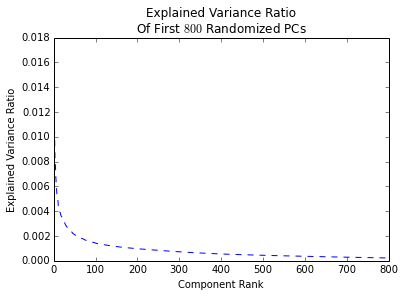

_Figure 6: Plot of our explained variance ratio for the first $800$ components of the randomized PCA on our dataset._

The sum of the first $800$ randomized principal components accounts for $70.45\%$ of the explained variance in the data.

In [13]:
#plot explained variance
plt.plot(range(len(languagePCA.explained_variance_ratio_)),languagePCA.explained_variance_ratio_,"--")
plt.xlabel("Component Rank")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio\nOf First $800$ Randomized PCs")
plt.show()
printmd("_Figure 6: Plot of our explained variance ratio for the first $800$ components of the"
        + " randomized PCA on our dataset._")
#get sum of first 99%
printmd("The sum of the first $800$ randomized principal components accounts for $"
       + str(np.round(np.sum(languagePCA.explained_variance_ratio_) * 100,2)) 
       + "\%$ of the explained variance in the data.")

This is not the best reduction that we could be doing, but to offset the costly runtime of performing a full PCA on our TF-IDF encodings, it seems reasonable to simply reduce our encodings to around $800$ features. This will also make the classification runtimes more reasonable given the fewer number of features that we will be considering.

In [9]:
reducedLanguageFeatures = languagePCA.transform(languageFrame)

In [10]:
reducedLangCols = [("PC " + str(i)) for i in xrange(800)]
reducedLangFrame = pd.DataFrame(reducedLanguageFeatures,columns = reducedLangCols)

### Initial Modeling

For the sake of first benchmarking simple classifiers, we will initially model our outcome using decision trees and logistic regressions. It is very likely that the true decision surface is much more complex than what these two model families are capable of, but we will consider this in a future step. For the variables we will consider we will use all $800$ features of our reduced language model and our company response categorical variable. We choose to include this categorical variable due to the very likely possibility that consumers will probably dispute a resolution based on how effective the company was at resolving their complaint.

#### Lasso Logistic Regression

We will first consider an $L_2$ logistic regression to study relevant features for fitting.

In [11]:
from sklearn import linear_model
#get appended language frame
appendedReducLangFrame = reducedLangFrame
#encode company response to consumer
from sklearn import preprocessing
companyResponseSeries = complaintNarrativeFrame["company_response_to_consumer"]
companyResponseEncoding = preprocessing.LabelEncoder()
encodedCompanyResponseSeries = companyResponseEncoding.fit_transform(companyResponseSeries)
#encode disputes
disputeSeries = complaintNarrativeFrame["consumer_disputed?"]
disputeEncoding = preprocessing.LabelEncoder()
encodedDisputeSeries = disputeEncoding.fit_transform(disputeSeries)
#then append our reduced language frame with our dummy variables
for i in xrange(len(np.unique(encodedCompanyResponseSeries)) - 1): #leave one out for
    #dummy variables
    companyLev = np.unique(encodedCompanyResponseSeries)[i]
    appendedReducLangFrame[companyResponseEncoding.classes_[companyLev]] = 0
    print companyResponseEncoding.classes_[companyLev]
    appendedReducLangFrame.loc[encodedCompanyResponseSeries == companyLev,
                               companyResponseEncoding.classes_[companyLev]] = 1
#then fit
initialLogMod = linear_model.LogisticRegression(penalty = 'l2')
initialLogMod.fit(appendedReducLangFrame,encodedDisputeSeries)

Closed
Closed with explanation
Closed with monetary relief
Closed with non-monetary relief


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
#check fit of our decision tree
from sklearn import metrics
currentAccuracy = metrics.accuracy_score(encodedDisputeSeries,
                             initialLogMod.predict(appendedReducLangFrame))
printmd("Our current accuracy on the full dataset with the $L_2$ logistic regression is $"
       + str(np.round(currentAccuracy,2)) + "$.")

Our current accuracy on the full dataset with the $L_2$ logistic regression is $0.77$.

This is not the best accuracy to start from, but it is a reasonable model for our current dataset. Let us look at the top $10$ and bottom $10$ coefficients in terms of their absolute value.

In [16]:
coefSeries = pd.Series(initialLogMod.coef_[0],index = appendedReducLangFrame.columns)
coefFrame = pd.DataFrame()
coefFrame["Coefficient"] = coefSeries
coefFrame["Absolute Coefficient"] = np.abs(coefFrame["Coefficient"])
#then order it
coefFrame = coefFrame.sort_values("Absolute Coefficient",ascending = False)
topTenCoeffs = coefFrame.iloc[0:10,:]
bottomTenCoeffs = coefFrame.iloc[(coefFrame.shape[0]-10):coefFrame.shape[0],:]
display(topTenCoeffs)
printmd("_Table 3: Top $10$ coefficients of our logistic regression"
        + " in terms of absolute value._")
display(bottomTenCoeffs)
printmd("_Table 4: Bottom $10$ coefficients of our logistic regression in terms of absolute "
       + "value._")

,Coefficient,Absolute Coefficient
Closed,2.814890,2.814890
Closed with explanation,2.571046,2.571046
PC 71,2.244042,2.244042
PC 46,-2.088127,2.088127
PC 79,-1.908447,1.908447
PC 10,-1.905461,1.905461
Closed with non-monetary relief,1.743661,1.743661
PC 330,-1.723339,1.723339
PC 779,1.643092,1.643092
PC 744,-1.627708,1.627708


_Table 3: Top $10$ coefficients of our logistic regression in terms of absolute value._

,Coefficient,Absolute Coefficient
PC 757,0.005174,0.005174
PC 532,-0.005080,0.005080
PC 398,0.004833,0.004833
PC 237,0.003740,0.003740
PC 215,-0.003736,0.003736
PC 61,0.003088,0.003088
PC 518,0.001521,0.001521
PC 404,-0.001449,0.001449
PC 33,0.000627,0.000627
PC 317,0.000611,0.000611


_Table 4: Bottom $10$ coefficients of our logistic regression in terms of absolute value._

We see that $3$ of our levels for company response climb to the top of meaningful variables for figuring out if a consumer will dispute an outcome, and very quickly the magnitude of our coefficients lighten up as we begin to consider our principal components. This suggests that our components are not as effective at predicting consumer disputes as simply the company response. That being said, we see that the $71$st, $46$th, $79$th, and $10$th principal components do seem to provide some meaningful predictive effects. Let's take a look at these principal components in order to provide interpretation to them.

In [23]:
def getOrderedWords(givenPCInd):
    #helper that gets a list of ordered words from highest to lowest based on a particular
    #principal component
    givenPC = pd.Series(languagePCA.components_[givenPCInd,:],index = languageFrame.columns)
    givenPC = givenPC.sort_values(ascending = False)
    return list(givenPC.index)
consideredPCs = [71,46,79,10] #list of PCs we care about
wordArray = [getOrderedWords(i) for i in consideredPCs]
colNameArray = [("PC " + str(i)) for i in consideredPCs]
wordFrame = pd.DataFrame(np.array(wordArray).T,columns = colNameArray)
display(wordFrame)
printmd("Table 5: Our four principal components with the highest coefficients from our "
       + "regression, with the words ordered from highest to lowest weight in the given "
       + "principal component.")

ValueError: Wrong number of items passed 13962, placement implies 13966

I am personally finding it difficult to interpret these four principal components, although I would be very interested in recieving some potential candidate interpretation in the feedback on this notebook.

Given that we are generally seeing principal components that do not seem to have very meaningful or interpretable predictive power, I think we should simply consider a regression on the raw TF-IDF encodings of our variables along with our encoding for company response.

#### $L_1$ Logistic Regression

To initially select relevant features from our raw TF-IDF encoding appended with company response dummy variables, We will perform an $L_1$ logistic regression and analyze the variables that are given non-zero coefficients.

In [18]:
appendedLangFrame = languageFrame
#add company response to this appended language frame
for i in xrange(len(np.unique(encodedCompanyResponseSeries)) - 1): #leave one out for
    #dummy variables
    companyLev = np.unique(encodedCompanyResponseSeries)[i]
    appendedLangFrame[companyResponseEncoding.classes_[companyLev]] = 0
    print companyResponseEncoding.classes_[companyLev]
    appendedLangFrame.loc[encodedCompanyResponseSeries == companyLev,
                         companyResponseEncoding.classes_[companyLev]] = 1

Closed
Closed with explanation
Closed with monetary relief
Closed with non-monetary relief


In [19]:
#then perform our logistic regression
absRegularLogMod = linear_model.LogisticRegression(penalty = 'l1')
absRegularLogMod.fit(appendedLangFrame,encodedDisputeSeries)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
#check fit
currentAccuracy = metrics.accuracy_score(encodedDisputeSeries,
                             absRegularLogMod.predict(appendedLangFrame))
printmd("Our current accuracy on the full dataset with the $L_1$ logistic regression is $"
       + str(np.round(currentAccuracy,2)) + "$.")

Our current accuracy on the full dataset with the $L_2$ logistic regression is $0.77$.

Interesting, we are performing about as well with this model as we were performing with our $L_2$ regression on the principal components. That being said, this regression has a much more reasonable interpretability than our principal component-based $L_2$ regression.

Let us see how many of our coefficients have been assigned non-zero coefficients within the $L_1$ regression as well as observe the top $15$ coefficients in terms of their absolute value.

In [26]:
coefSeries = pd.Series(absRegularLogMod.coef_[0],index = appendedLangFrame.columns)
coefFrame = pd.DataFrame()
coefFrame["Coefficient"] = coefSeries
coefFrame["Absolute Coefficient"] = np.abs(coefFrame["Coefficient"])
numNonZero = coefFrame[coefFrame["Coefficient"] != 0].shape[0]
propNonZero = float(numNonZero) / coefFrame.shape[0]
#then order it
maxNum = 15
coefFrame = coefFrame.sort_values("Absolute Coefficient",ascending = False)
topFifteenCoeffs = coefFrame.iloc[0:maxNum,:]
display(topFifteenCoeffs)
printmd("_Table 6: Top $" + str(maxNum) + "$ coefficients of our $L_1$ logistic regression"
        + " in terms of absolute value._")
printmd("There are $" + str(np.round(numNonZero,2)) + "$ variables with non-zero "
        + "coefficients, or $" + str(np.round(propNonZero * 100,2)) + "\%$ of our features.")

,Coefficient,Absolute Coefficient
boat,3.988623,3.988623
tracing,3.789147,3.789147
oracle,3.757609,3.757609
Closed,3.507975,3.507975
Closed with explanation,3.267797,3.267797
condor,3.150351,3.150351
boarding,2.976690,2.976690
speaker,2.906657,2.906657
insecure,2.883361,2.883361
phony,2.852108,2.852108


_Table 6: Top $15$ coefficients of our $L_1$ logistic regression in terms of absolute value._

There are $1482$ variables with non-zero coefficients, or $10.61\%$ of our features.

While these are slightly more variables than the $800$ randomized principal components that we were originally considering, this number of variables is much more reasonable to deal with than over $10000$ variables. Thus, for now, we will select these variables as we progress with our initial models.

In [29]:
coefNonZeroFrame = coefFrame[coefFrame["Coefficient"] != 0]
reducLangFrame = appendedLangFrame.loc[:,coefNonZeroFrame.index]

With this new reduced set of variables, let us see how these variables perform in an $L_2$ logistic regression.

In [30]:
newLogMod = linear_model.LogisticRegression(penalty = 'l2')
newLogMod.fit(reducLangFrame,encodedDisputeSeries)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
currentAccuracy = metrics.accuracy_score(encodedDisputeSeries,
                             newLogMod.predict(reducLangFrame))
printmd("Our current accuracy on the full dataset with the $L_2$ logistic regression is $"
       + str(np.round(currentAccuracy,2)) + "$.")

Our current accuracy on the full dataset with the $L_1$ logistic regression is $0.77$.

We are still not making progress on accuracy, which suggests that we may need to do a lot of diagnostic work to find potentially a better logistic model as well as consider other nonlinear methods.

For now, let us look at the confusion matrix for this model.

In [60]:
confusionMatrix = pd.DataFrame([[0,0],[0,0]],index = ["Actually 0","Actually 1"],
                                             columns = ["Predicted 0","Predicted 1"])
predictedOutcomes = newLogMod.predict(reducLangFrame)
outcomeArray = pd.DataFrame(np.array([encodedDisputeSeries,predictedOutcomes]).T,
                            columns = ["Actual","Predicted"])
#then add our information
for i in xrange(2):
    for j in xrange(2):
        #subset our outcomes
        subsettedOutcomeArray = outcomeArray.loc[outcomeArray.iloc[:,0] == i,:]
        subsettedOutcomeArray = subsettedOutcomeArray.loc[
                                        subsettedOutcomeArray.iloc[:,1] == j,:]
        #then get the shape of these outcomes
        confusionMatrix.iloc[i,j] = subsettedOutcomeArray.shape[0]
display(confusionMatrix)
printmd("Table 7: Our confusion matrix for the $L_2$ logistic regression over our $L_1$-"
       + "reduced variables.")


,Predicted 0,Predicted 1
Actually 0,50629,600
Actually 1,14477,1100


Table 7: Our confusion matrix for the $L_2$ logistic regression over our $L_1$-reduced variables.

We can see that we currently have a very high false negative rate, which accounts for around $21.67\%$ of our predictions. This suggests that we may need to do more to increase the ability to predict disputes.

TODO:

* Fix Color Scheme For Figure 4

* Fix $x$-ticks on Figure 2

In [52]:
help(np.where)

Help on built-in function where in module numpy.core.multiarray:

where(...)
    where(condition, [x, y])
    
    Return elements, either from `x` or `y`, depending on `condition`.
    
    If only `condition` is given, return ``condition.nonzero()``.
    
    Parameters
    ----------
    condition : array_like, bool
        When True, yield `x`, otherwise yield `y`.
    x, y : array_like, optional
        Values from which to choose. `x` and `y` need to have the same
        shape as `condition`.
    
    Returns
    -------
    out : ndarray or tuple of ndarrays
        If both `x` and `y` are specified, the output array contains
        elements of `x` where `condition` is True, and elements from
        `y` elsewhere.
    
        If only `condition` is given, return the tuple
        ``condition.nonzero()``, the indices where `condition` is True.
    
    See Also
    --------
    nonzero, choose
    
    Notes
    -----
    If `x` and `y` are given and input arrays are 1-D, `wh